In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['font.sans-serif'] = ['SimHei']
data = pd.read_excel('数据科学实践Data/NSGAII-MV.xlsx', header=2, index_col=1).drop(columns='Unnamed: 0').dropna()

In [2]:
returns = data.values
mu = np.mean(returns, axis=0)
sigma = np.cov(returns, rowvar=False)

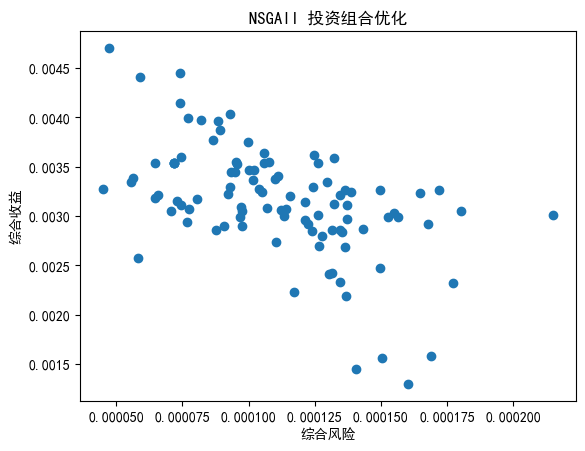

In [3]:

N = 10  # 资产种类
population_size = 100  # 种群大小
generations = 200  # 迭代次数
crossover_rate = 0.9  # 交叉概率
mutation_rate = 0.1  # 变异概率

def initialize_population(pop_size, num_assets):
    population = np.random.rand(pop_size, num_assets)
    population = population / population.sum(axis=1, keepdims=True)
    return population

# 评估种群
def evaluate_population(population, mu, sigma):
    f1 = np.dot(population, mu)
    f2 = np.einsum('ij,ji->i', np.dot(population, sigma), population.T)
    return f1, f2

# 非支配排序
def non_dominated_sorting(f1, f2):
    S = [[] for _ in range(len(f1))]
    front = [[]]
    n = [0] * len(f1)
    rank = [0] * len(f1)

    for p in range(len(f1)):
        for q in range(len(f1)):
            if (f1[p] >= f1[q] and f2[p] <= f2[q]) and (f1[p] > f1[q] or f2[p] < f2[q]):
                S[p].append(q)
            elif (f1[q] >= f1[p] and f2[q] <= f2[p]) and (f1[q] > f1[p] or f2[q] < f2[p]):
                n[p] += 1
        if n[p] == 0:
            rank[p] = 0
            front[0].append(p)

    i = 0
    while front[i]:
        Q = []
        for p in front[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    Q.append(q)
        i += 1
        front.append(Q)

    del front[-1]
    return front

# 拥挤度计算
def calculate_crowding_distance(f1, f2, front):
    distance = [0] * len(f1)
    for i in range(len(front)):
        f1_values = [f1[j] for j in front[i]]
        f2_values = [f2[j] for j in front[i]]
        sorted_f1 = np.argsort(f1_values)
        sorted_f2 = np.argsort(f2_values)
        distance[front[i][sorted_f1[0]]] = distance[front[i][sorted_f1[-1]]] = float('inf')
        distance[front[i][sorted_f2[0]]] = distance[front[i][sorted_f2[-1]]] = float('inf')
        for j in range(1, len(front[i]) - 1):
            distance[front[i][sorted_f1[j]]] += (f1_values[sorted_f1[j + 1]] - f1_values[sorted_f1[j - 1]]) / (max(f1_values) - min(f1_values))
            distance[front[i][sorted_f2[j]]] += (f2_values[sorted_f2[j + 1]] - f2_values[sorted_f2[j - 1]]) / (max(f2_values) - min(f2_values))
    return distance

# 选择
def selection(population, f1, f2, front, distance):
    new_population = []
    for i in range(len(front)):
        front[i] = sorted(front[i], key=lambda x: distance[x], reverse=True)
        new_population.extend(front[i])
    return population[new_population[:population_size]]

# 交叉
def crossover(parent1, parent2):
    if np.random.rand() < crossover_rate:
        point = np.random.randint(1, len(parent1) - 1)
        child1 = np.concatenate((parent1[:point], parent2[point:]))
        child2 = np.concatenate((parent2[:point], parent1[point:]))
        return child1, child2
    else:
        return parent1, parent2

# 变异
def mutation(child):
    if np.random.rand() < mutation_rate:
        point = np.random.randint(len(child))
        child[point] = np.random.rand()
    return child / child.sum()

# 主函数
population = initialize_population(population_size, N)
for generation in range(generations):
    f1, f2 = evaluate_population(population, mu, sigma)
    front = non_dominated_sorting(f1, f2)
    distance = calculate_crowding_distance(f1, f2, front)
    new_population = []
    while len(new_population) < population_size:
        parent1, parent2 = population[np.random.randint(population_size)], population[np.random.randint(population_size)]
        child1, child2 = crossover(parent1, parent2)
        new_population.append(mutation(child1))
        if len(new_population) < population_size:
            new_population.append(mutation(child2))
    population = selection(np.array(new_population), f1, f2, front, distance)

# 绘制结果
f1, f2 = evaluate_population(population, mu, sigma)
plt.scatter(f2, f1)
plt.xlabel('综合风险')
plt.ylabel('综合收益')
plt.title('NSGAII 投资组合优化')
plt.show()

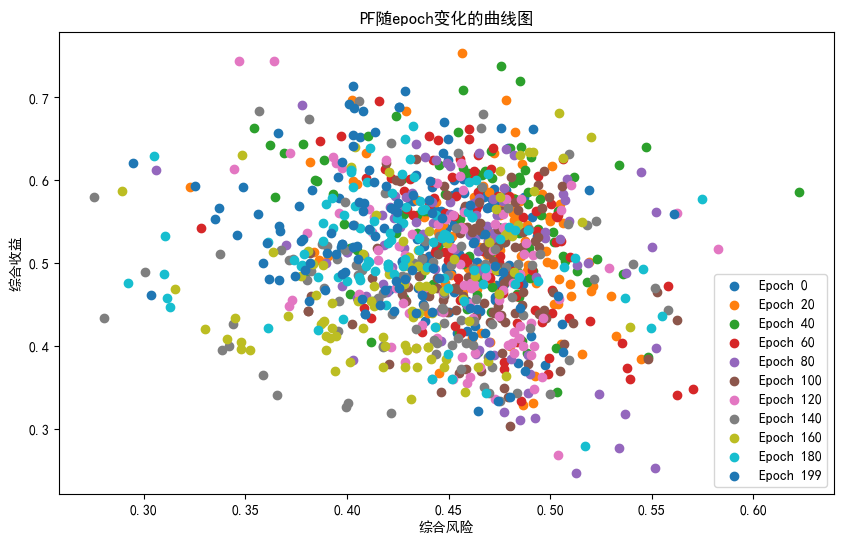

最优值f^opt: 0.720072184528947
对应的变量X^opt: [0.01010271 0.15122763 0.47324318 0.05080092 0.00311143 0.00741462
 0.05203047 0.10712576 0.04108022 0.10386307]


In [4]:
POP = 100  # 种群大小
max_epoch = 200  # 最大迭代次数
Pcross = 0.9  # 交叉概率
Pmutate = 0.1  # 变异概率
Stype = 'tournament'  # 选择操作类型

# 随机生成资产的平均收益率和协方差矩阵
np.random.seed(42)
mu = np.random.rand(N)
sigma = np.random.rand(N, N)
sigma = (sigma + sigma.T) / 2 
population = initialize_population(POP, N)
pareto_fronts = []

for epoch in range(max_epoch):
    f1, f2 = evaluate_population(population, mu, sigma)
    front = non_dominated_sorting(f1, f2)
    distance = calculate_crowding_distance(f1, f2, front)
    new_population = []
    while len(new_population) < POP:
        parent1, parent2 = population[np.random.randint(POP)], population[np.random.randint(POP)]
        child1, child2 = crossover(parent1, parent2)
        new_population.append(mutation(child1))
        if len(new_population) < POP:
            new_population.append(mutation(child2))
    population = selection(np.array(new_population), f1, f2, front, distance)
    pareto_fronts.append((f1, f2))

# 绘制PF随epoch变化的曲线图
plt.figure(figsize=(10, 6))
for epoch, (f1, f2) in enumerate(pareto_fronts):
    if epoch % 20 == 0 or epoch == max_epoch - 1:
        plt.scatter(f2, f1, label=f'Epoch {epoch}')
plt.xlabel('综合风险')
plt.ylabel('综合收益')
plt.title('PF随epoch变化的曲线图')
plt.legend()
plt.show()

# 输出最优值f^opt及对应的变量X^opt
f1, f2 = evaluate_population(population, mu, sigma)
front = non_dominated_sorting(f1, f2)[0]
optimal_index = np.argmax(f1[front])
f_opt = f1[front][optimal_index]
X_opt = population[front][optimal_index]

print(f'最优值f^opt: {f_opt}')
print(f'对应的变量X^opt: {X_opt}')

/tmp/ipykernel_6478/3832752259.py:61: RuntimeWarning: invalid value encountered in scalar divide
  distance[front[i][sorted_f1[j]]] += (f1_values[sorted_f1[j + 1]] - f1_values[sorted_f1[j - 1]]) / (max(f1_values) - min(f1_values))
/tmp/ipykernel_6478/3832752259.py:62: RuntimeWarning: invalid value encountered in scalar divide
  distance[front[i][sorted_f2[j]]] += (f2_values[sorted_f2[j + 1]] - f2_values[sorted_f2[j - 1]]) / (max(f2_values) - min(f2_values))


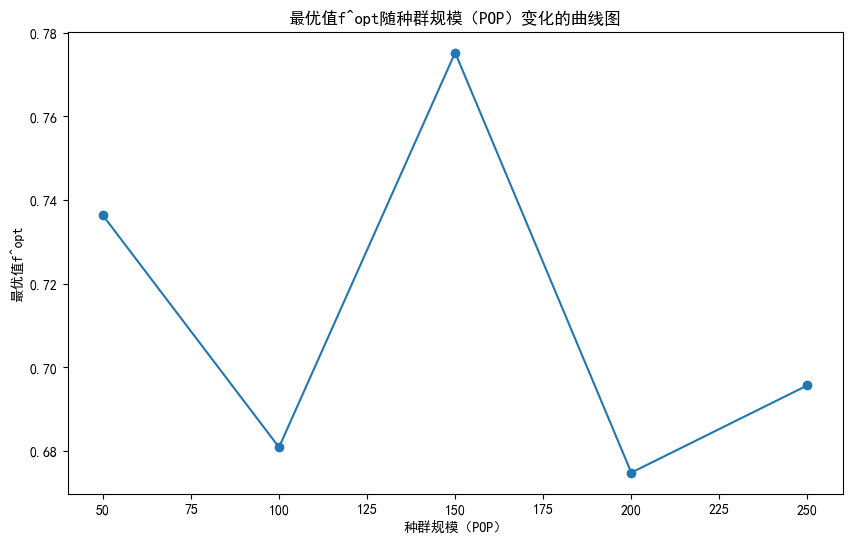

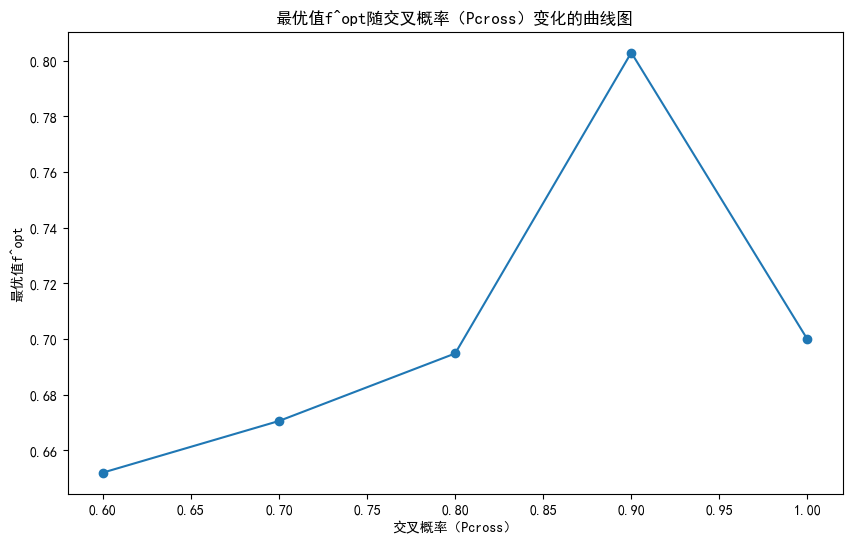

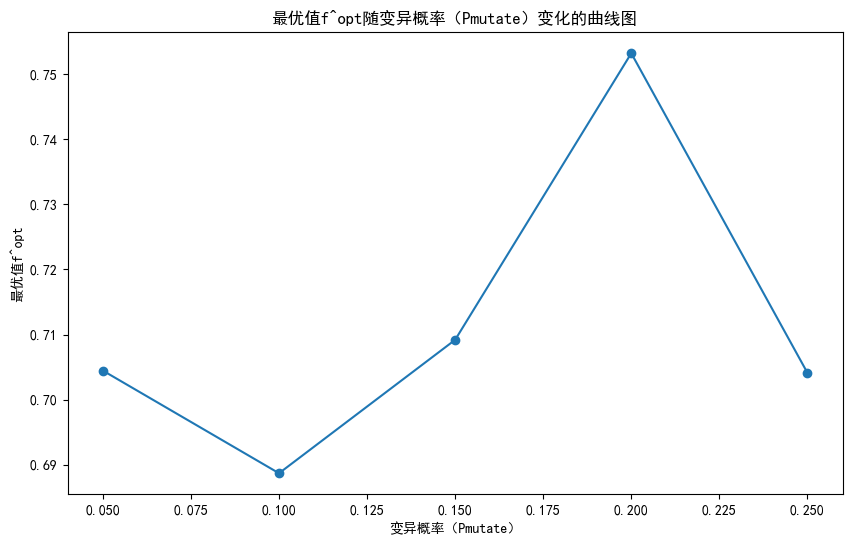

In [5]:
def run_nsga2(POP, Pcross, Pmutate):
    population = initialize_population(POP, N)
    for epoch in range(max_epoch):
        f1, f2 = evaluate_population(population, mu, sigma)
        front = non_dominated_sorting(f1, f2)
        distance = calculate_crowding_distance(f1, f2, front)
        new_population = []
        while len(new_population) < POP:
            parent1, parent2 = population[np.random.randint(len(population))], population[np.random.randint(len(population))]
            child1, child2 = crossover(parent1, parent2)
            new_population.append(mutation(child1))
            if len(new_population) < POP:
                new_population.append(mutation(child2))
        population = selection(np.array(new_population), f1, f2, front, distance)
    f1, f2 = evaluate_population(population, mu, sigma)
    front = non_dominated_sorting(f1, f2)[0]
    optimal_index = np.argmax(f1[front])
    f_opt = f1[front][optimal_index]
    return f_opt

# 优化种群规模（POP）
pop_values = [50, 100, 150, 200, 250]
pop_results = []

for pop in pop_values:
    f_opt = run_nsga2(pop, Pcross, Pmutate)
    pop_results.append(f_opt)

plt.figure(figsize=(10, 6))
plt.plot(pop_values, pop_results, marker='o')
plt.xlabel('种群规模（POP）')
plt.ylabel('最优值f^opt')
plt.title('最优值f^opt随种群规模（POP）变化的曲线图')
plt.show()

# 优化交叉概率（Pcross）
pcross_values = [0.6, 0.7, 0.8, 0.9, 1.0]
pcross_results = []

for pcross in pcross_values:
    f_opt = run_nsga2(POP, pcross, Pmutate)
    pcross_results.append(f_opt)

plt.figure(figsize=(10, 6))
plt.plot(pcross_values, pcross_results, marker='o')
plt.xlabel('交叉概率（Pcross）')
plt.ylabel('最优值f^opt')
plt.title('最优值f^opt随交叉概率（Pcross）变化的曲线图')
plt.show()

# 优化变异概率（Pmutate）
pmutate_values = [0.05, 0.1, 0.15, 0.2, 0.25]
pmutate_results = []

for pmutate in pmutate_values:
    f_opt = run_nsga2(POP, Pcross, pmutate)
    pmutate_results.append(f_opt)

plt.figure(figsize=(10, 6))
plt.plot(pmutate_values, pmutate_results, marker='o')
plt.xlabel('变异概率（Pmutate）')
plt.ylabel('最优值f^opt')
plt.title('最优值f^opt随变异概率（Pmutate）变化的曲线图')
plt.show()

/tmp/ipykernel_6478/3832752259.py:61: RuntimeWarning: invalid value encountered in scalar divide
  distance[front[i][sorted_f1[j]]] += (f1_values[sorted_f1[j + 1]] - f1_values[sorted_f1[j - 1]]) / (max(f1_values) - min(f1_values))
/tmp/ipykernel_6478/3832752259.py:62: RuntimeWarning: invalid value encountered in scalar divide
  distance[front[i][sorted_f2[j]]] += (f2_values[sorted_f2[j + 1]] - f2_values[sorted_f2[j - 1]]) / (max(f2_values) - min(f2_values))


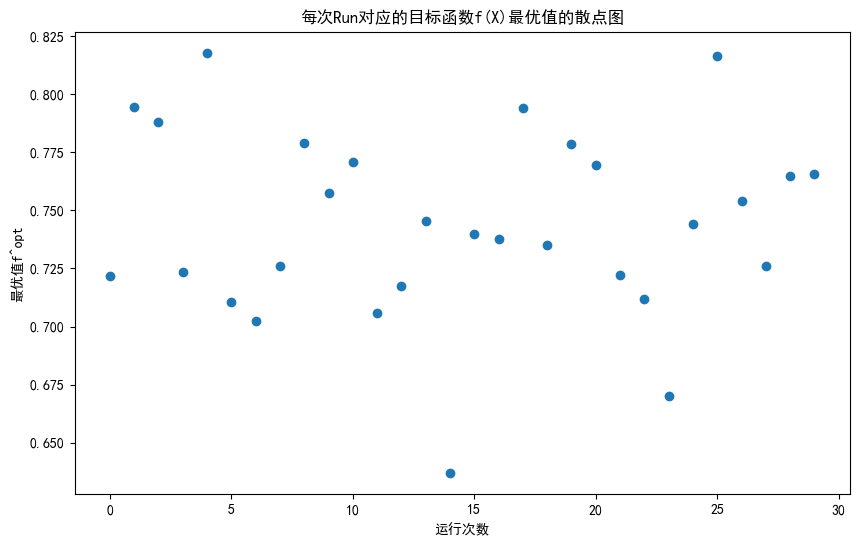

全局最优值f^*: 0.8177071434598546
对应的变量X^*: [0.04266268 0.45188957 0.05509187 0.00338596 0.00390289 0.00187004
 0.00780149 0.14192112 0.00851783 0.28295655]


In [6]:
POP = 150  # 种群大小
Pcross = 0.9  # 交叉概率
Pmutate = 0.2  # 变异概率
def run_nsga2():
    population = initialize_population(POP, N)
    for epoch in range(max_epoch):
        f1, f2 = evaluate_population(population, mu, sigma)
        front = non_dominated_sorting(f1, f2)
        distance = calculate_crowding_distance(f1, f2, front)
        new_population = []
        while len(new_population) < POP:
            parent1, parent2 = population[np.random.randint(len(population))], population[np.random.randint(len(population))]
            child1, child2 = crossover(parent1, parent2)
            new_population.append(mutation(child1))
            if len(new_population) < POP:
                new_population.append(mutation(child2))
        population = selection(np.array(new_population), f1, f2, front, distance)
    f1, f2 = evaluate_population(population, mu, sigma)
    front = non_dominated_sorting(f1, f2)[0]
    optimal_index = np.argmax(f1[front])
    f_opt = f1[front][optimal_index]
    X_opt = population[front][optimal_index]
    return f_opt, X_opt

# 多次运行算法
num_runs = 30
results = []

for _ in range(num_runs):
    f_opt, X_opt = run_nsga2()
    results.append((f_opt, X_opt))

# 绘制每次Run对应的目标函数f(X)最优值的散点图
f_opts = [result[0] for result in results]
plt.figure(figsize=(10, 6))
plt.scatter(range(num_runs), f_opts)
plt.xlabel('运行次数')
plt.ylabel('最优值f^opt')
plt.title('每次Run对应的目标函数f(X)最优值的散点图')
plt.show()

# 输出全局最优值f^*及对应的变量X^*
global_opt_index = np.argmax(f_opts)
f_star = f_opts[global_opt_index]
X_star = results[global_opt_index][1]

print(f'全局最优值f^*: {f_star}')
print(f'对应的变量X^*: {X_star}')